# DTLZ2 Benchmark
## Imports

In [20]:
from bofire.benchmarks.multi import DTLZ2
from bofire.benchmarks.benchmark import run
from bofire.utils.multiobjective import compute_hypervolume
from bofire.samplers import PolytopeSampler
from bofire.strategies.random import RandomStrategy
from bofire.domain import Domain
from bofire.strategies.botorch.qehvi import BoTorchQehviStrategy
from functools import partial

## Random Strategy

In [23]:
def sample(domain):
    sampler = PolytopeSampler(domain=domain)
    sampled = sampler.ask(10)
    return sampled

def hypervolume(domain: Domain) -> float:
    assert domain.experiments is not None
    return compute_hypervolume(
        domain, domain.experiments, ref_point={"f_0": 1.1, "f_1": 1.1}
    )

random_results = run(
    DTLZ2(dim=6),
    strategy_factory=RandomStrategy,
    n_iterations=50,
    metric=hypervolume,
    #initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.071: 100%|██████████| 50/50 [00:00<00:00, 123.55it/s]


## QEHVI Strategy

In [21]:
results = run(
    DTLZ2(dim=6),
    strategy_factory=partial(BoTorchQehviStrategy, ref_point={"f_0": 1.1, "f_1": 1.1}),
    n_iterations=50,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.393: 100%|██████████| 50/50 [02:47<00:00,  3.36s/it]


## Performance Plot

Text(0, 0.5, 'f_1')

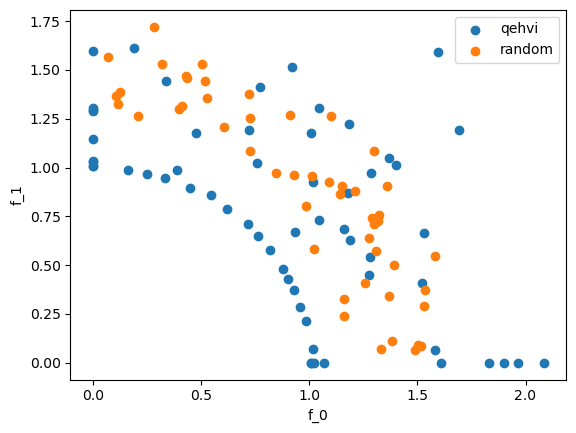

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(results[0][0].domain.experiments.f_0, results[0][0].domain.experiments.f_1, label = "qehvi")
ax.scatter(random_results[0][0].domain.experiments.f_0, random_results[0][0].domain.experiments.f_1, label = "random")

ax.legend()

ax.set_xlabel("f_0")
ax.set_ylabel("f_1")